In [1]:
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
from skimage.feature import graycomatrix, graycoprops
import numpy as np

train_dir = Path('../assets/clahe_images_full')
data_filepaths = list(train_dir.glob(r'**/*.jpg'))

print(len(data_filepaths))

2874


In [266]:
def proc_img(filepath):
    """
    Spracovanie ciest k obrazovým súborom na extrakciu labelov a vytvorenie DataFrame.

    Args:
    - (zoznam): Zoznam ciest k súborom.

    Returns: Súbor súborov (zoznam súborov):
    - df (DataFrame): Pandas DataFrame obsahujúci cesty k súborom a labele.
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [278]:
df = proc_img(data_filepaths)

In [268]:
df.head()

,Filepath,Label
0,clahe_images_full\normal\G1020-740_roi.jpg,normal
1,clahe_images_full\glaucoma\G1020-586_roi.jpg,glaucoma
2,clahe_images_full\normal\FIVES-172_roi.jpg,normal
3,clahe_images_full\glaucoma\EyePACS-Glaucoma-19...,glaucoma
4,clahe_images_full\glaucoma\EyePACS-Glaucoma-25...,glaucoma


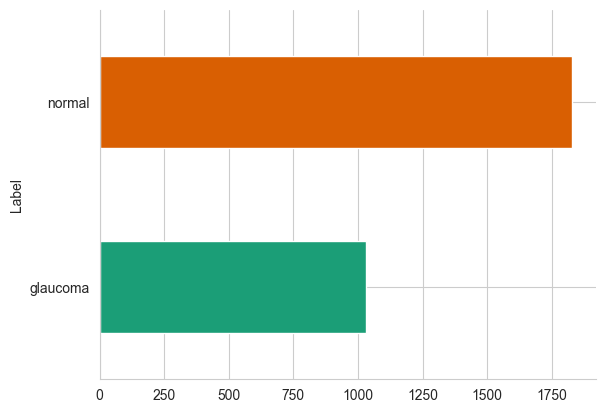

In [250]:
from matplotlib import pyplot as plt
import seaborn as sns

df.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [279]:
import pandas as pd

# Vyváženie súboru údajov nadvzorkovaním menšinovej triedy ("glaucomam") tak, aby sa počet vzoriek zhodoval s počtom vzoriek vo väčšinovej triede ("normal").

total_samples = 4000
num_normal_samples = total_samples // 2
num_glaucoma_samples = total_samples - num_normal_samples

normal_data = df[df["Label"] == "normal"]
glaucoma_data = df[df["Label"] == "glaucoma"]

oversampled_glaucoma_data = glaucoma_data.sample(n=num_glaucoma_samples, replace=True)

oversampled_normal_data = normal_data.sample(n=num_normal_samples, replace=True)

balanced_df = pd.concat([oversampled_glaucoma_data, oversampled_normal_data])

sample = balanced_df.sample(frac=1).reset_index(drop=True)

In [280]:
num_normal_samples = (sample["Label"] == "normal").sum()
num_glaucoma_samples = (sample["Label"] == "glaucoma").sum()

print("Number of samples for 'normal' class:", num_normal_samples)
print("Number of samples for 'glaucoma' class:", num_glaucoma_samples)

Number of samples for 'normal' class: 2000
Number of samples for 'glaucoma' class: 2000


In [231]:
def extract_features(image_path):
    """
    Extrahovanie textúrnych prvkov z obrázka pomocou GLCM (Gray Level Co-occurrence Matrix).

    Args:
    - image_path (str): Cesta k súboru s obrázkom.

    Returns:
    - features (ndarray): Zoskupené pole textúrnych vlastností (kontrast, energia, homogenita, korelácia).
    """
    
    img = cv2.imread(image_path, 0)  # Read image in grayscale
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0]
    energy = graycoprops(glcm, 'energy')[0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0]
    correlation = graycoprops(glcm, 'correlation')[0]
    return np.concatenate((contrast, energy, homogeneity, correlation))

In [232]:
def extract_features_from_dataframe(dataframe):
    """
    Extrahovanie textúrnych prvkov z obrázkov uvedených v DataFrame pomocou GLCM.

    Args:
    - Dataframe (DataFrame): Pandas DataFrame obsahujúci cesty k súborom a labele.

    Returns: (Vráti):
    - features_df (DataFrame): DataFrame obsahujúci extrahované textúrne vlastnosti a labele.
    """
    
    features_list = []
    for index, row in dataframe.iterrows():
        image_path = row['Filepath']
        label = row['Label']
        features = extract_features(image_path)
        features_list.append(np.concatenate((features, [label])))
    columns = ['Contrast', 'Energy', 'Homogeneity', 'Correlation', 'Label']
    return pd.DataFrame(features_list, columns=columns)

In [281]:
# Extract features from DataFrame
features_df = extract_features_from_dataframe(sample)

In [282]:
features_df.head()

,Contrast,Energy,Homogeneity,Correlation,Label
0,22.793935757093923,0.27409621480974095,0.529318759211558,0.9947599207085289,glaucoma
1,97.93689609833659,0.1813565401493535,0.3202836708514744,0.9792581958184736,normal
2,52.689548679060664,0.18996150965156405,0.36708134410347837,0.985314535766213,normal
3,38.73647718933463,0.2598867308559281,0.4612360643384018,0.9934924873607895,normal
4,15.882170376712327,0.25591626187574373,0.47771579151496074,0.9963048031960573,glaucoma


Text(0, 0.5, 'explained_variance_ratio_')

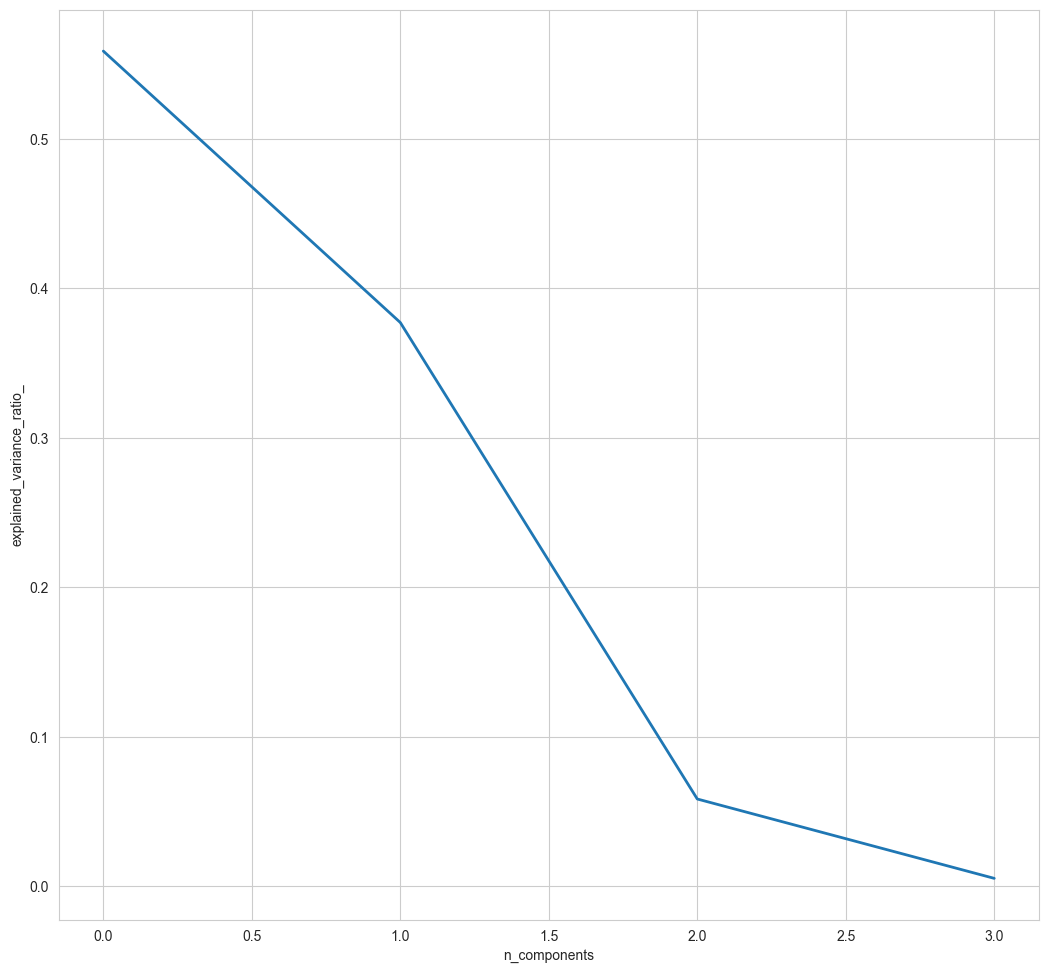

In [255]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

# Redukcia dimenzionality použitím PCA

features = features_df.drop(columns=['Label'])
scaler=StandardScaler()
ss=scaler.fit_transform(features)

pca = decomposition.PCA(n_components=min(features.shape[1],
                                             features.shape[0])).fit(ss)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [256]:
n_components=0
ratio = pca.explained_variance_ratio_
for i in range(features.shape[1]):
    a = ratio.cumsum()[i]
    if a >= 0.8:
        print("{} principal components explains 80% of variance ratio.".format(i))
        n_components=i
        break

1 principal components explaines  80% of the total variance
Sum of variance explained :93.6%


In [157]:
pca = decomposition.PCA(n_components=n_components)
d=pca.fit_transform(ss)

d=pd.DataFrame(d, columns=["PCA n°{}".format(i+1) for i in range(0,n_components) ])
d["Label"]=features_df["Label"].values

In [160]:
d.head()

,PCA n°1,Label
0,-1.637329,glaucoma
1,0.980556,normal
2,-1.379600,normal
3,0.106247,glaucoma
4,0.400151,glaucoma


In [283]:
# Split dataset into training and testing sets
y=features_df["Label"]
X=features_df.drop(columns=["Label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SVM

In [288]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
from sklearn.svm import SVC

# Trénovanie strojov s podpornými vektormi

svm = SVC(probability=True)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 300],  # Regularizačný parameter
    'gamma': ['scale'],  # gamma: 'scale', 'auto'
    'kernel': ['rbf']    # Funkcia jadra: 'rbf', 'poly', and 'sigmoid'
}

# 3-krížová validácia s prehľadavaním mriežky (najlepšie hyperparametre)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
grid_search.fit(scaled_train,y_train) 
svm_best = grid_search.best_estimator_
pred = svm_best.predict(scaled_test)
score= accuracy_score(y_test,pred)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END ....................C=0.01, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.6s
[CV] END ......................C=10, gamma=scale,

In [193]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 300, 'gamma': 'scale', 'kernel': 'rbf'}


In [306]:
print("Accuracy score:", round(score,4)," on the testing set with SVM.")

Accuracy score: 0.6725  on the testing set with SVM.


In [195]:
from sklearn.metrics import classification_report

print("SVM Classifier Report:")
print(classification_report(y_test, pred, digits=4))

SVM Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.5099    0.7803    0.6168       396
      normal     0.5515    0.2649    0.3579       404

    accuracy                         0.5200       800
   macro avg     0.5307    0.5226    0.4873       800
weighted avg     0.5309    0.5200    0.4860       800


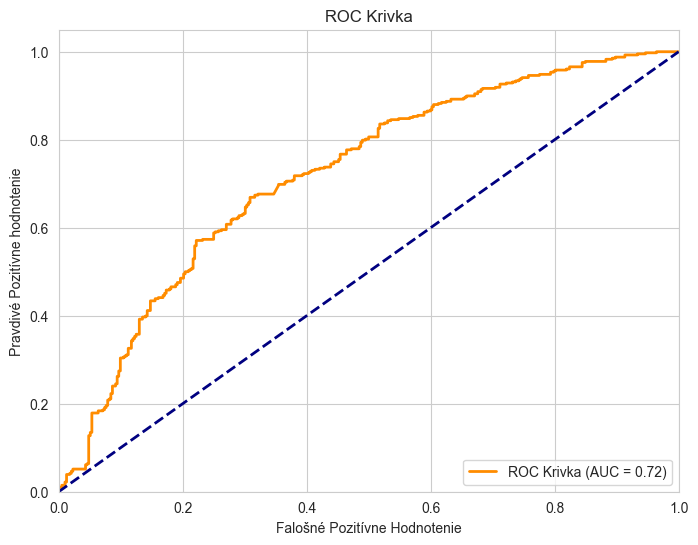

In [289]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Výpočet a vizualizácia ROC-AUC krivky

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = svm_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_svm, tpr_svm, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

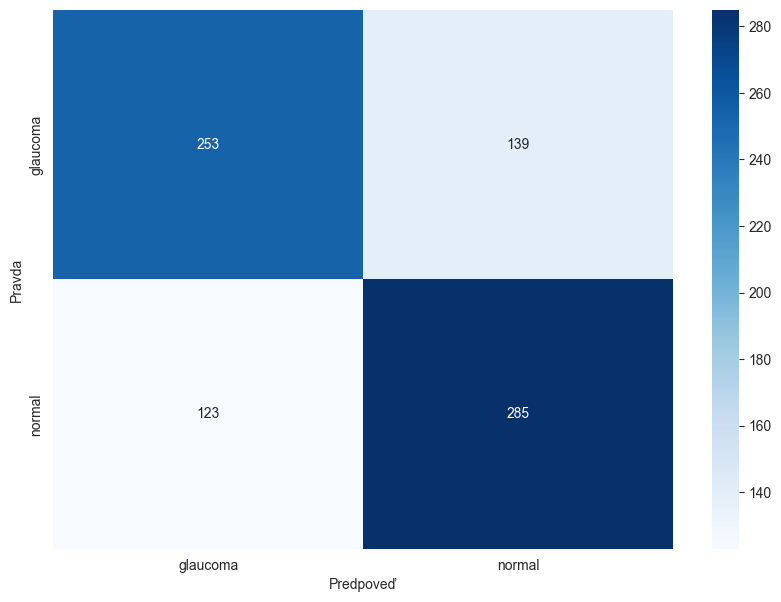

In [290]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

# Vizualizácia konfúznej matice

cm = confusion_matrix(y_test,pred)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_best.classes_, yticklabels=svm_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

RANDOM FORREST

In [284]:
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 300],  # Počet stromov
    'max_depth': [10, 20],      # Hĺbka stromu
    'max_features': ['sqrt', 'log2']  # Počet funkcií, ktoré treba zohľadniť pri každom rozdelení
}

rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

ss = StandardScaler()
scaled_train = ss.fit_transform(X_train)
scaled_test = ss.fit_transform(X_test)
grid_search_rf.fit(scaled_train,y_train)
rf_best = grid_search_rf.best_estimator_
pred_rf = rf_best.predict(scaled_test)
score2 = accuracy_score(y_test,pred_rf)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.9s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=300; total time=   1.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=300; total time=   1.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=300; total time=   1.7s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=10, max_features=log2, n_e

In [241]:
best_params = grid_search_rf.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}


In [305]:
print("Accuracy score:", round(score2,4)," on the testing set with random forest.")

Accuracy score: 0.7562  on the testing set with random forest.


In [260]:
print("Random Forest Classifier Report:")
print(classification_report(y_test, pred_rf, digits=4))

Random Forest Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.5565    0.6259    0.5892       401
      normal     0.5702    0.4987    0.5321       399

    accuracy                         0.5625       800
   macro avg     0.5634    0.5623    0.5606       800
weighted avg     0.5634    0.5625    0.5607       800


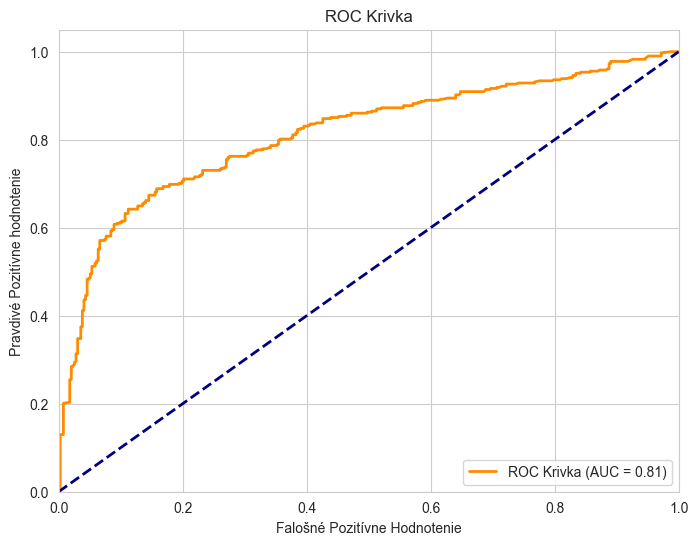

In [286]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Výpočet a vizualizácia ROC-AUC krivky

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = rf_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_rf, tpr_rf, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

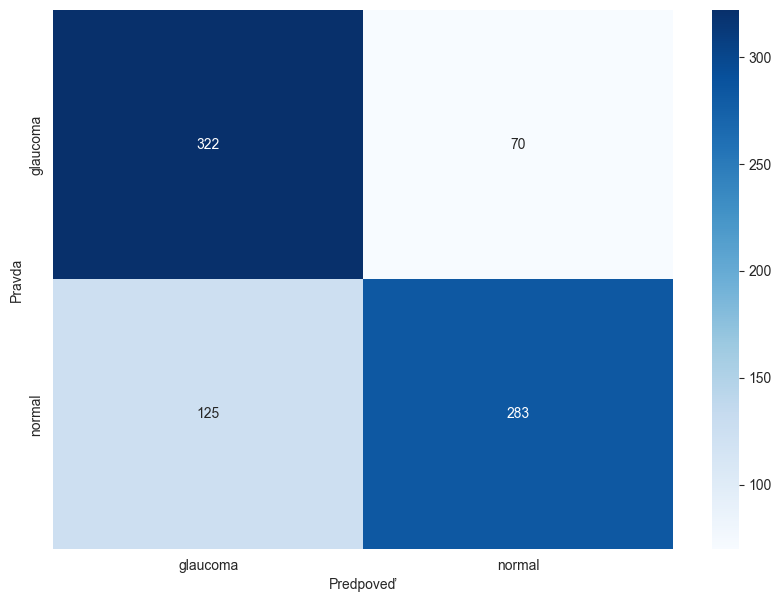

In [287]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

# Vizualizácia konfúznej matice

cm = confusion_matrix(y_test,pred_rf)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_best.classes_, yticklabels=rf_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

LOGISTIC REGRESSION

In [291]:
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression

param_grid = {
    'penalty': ['l2'],  # Penalizácia
    'C': [0.001, 0.01, 0.1, 1, 10, 100] # Regularizačná sila
}

lr = LogisticRegression()
ss = StandardScaler()
scaled_train = ss.fit_transform(X_train)
scaled_test = ss.fit_transform(X_test)
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_lr.fit(scaled_train, y_train)
lr_best = grid_search_lr.best_estimator_
pred_lr = lr_best.predict(scaled_test)
score3 = accuracy_score(y_test,pred_lr)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1,

In [205]:
best_params = grid_search_lr.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.01, 'penalty': 'l2'}


In [304]:
print("Accuracy score:", round(score3,4)," on the testing set with logistic regression.")

Accuracy score: 0.575  on the testing set with logistic regression.


In [207]:
print("Logistic Regression Classifier Report:")
print(classification_report(y_test, pred_lr, digits=4))

Logistic Regression Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.5785    0.7348    0.6474       396
      normal     0.6465    0.4752    0.5478       404

    accuracy                         0.6038       800
   macro avg     0.6125    0.6050    0.5976       800
weighted avg     0.6128    0.6038    0.5971       800


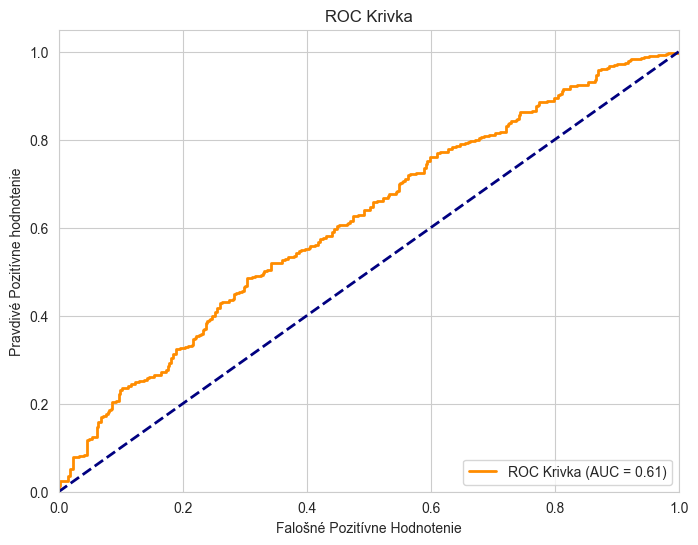

In [292]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = lr_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_lr, tpr_lr, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

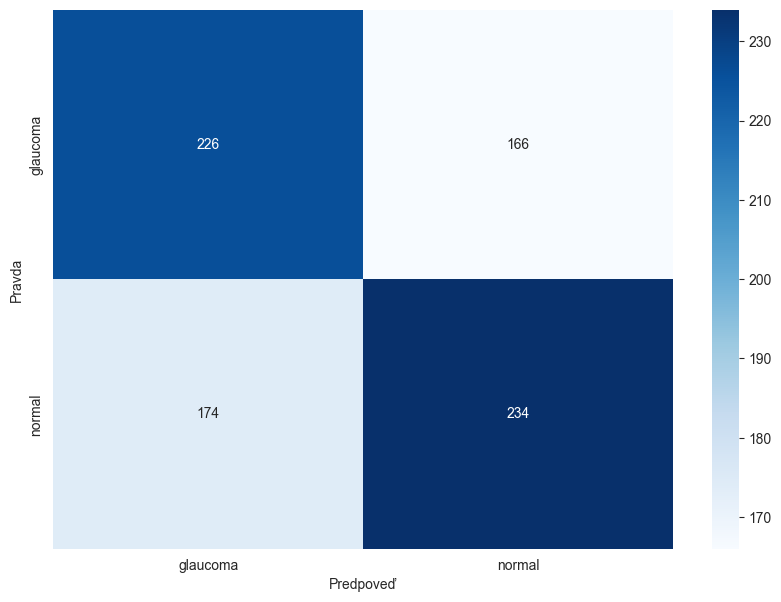

In [293]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm = confusion_matrix(y_test,pred_lr)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr_best.classes_, yticklabels=lr_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

KNN

In [294]:
from sklearn.metrics import accuracy_score 
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': range(1, 31),    # Počet susedov
    'weights': ['uniform', 'distance'],  # Váhova funkcia na predikciu
}

knn = KNeighborsClassifier()
ss=StandardScaler()
scaled_train=ss.fit_transform(X_train)
scaled_test=ss.fit_transform(X_test)
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_knn.fit(scaled_train, y_train)
knn_best = grid_search_knn.best_estimator_
pred_knn = knn_best.predict(scaled_test)
score5 = accuracy_score(y_test,pred_knn)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=1, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=1, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END .....................n_neighbors=2, weights=uniform; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=2, wei

In [211]:
best_params = grid_search_knn.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'n_neighbors': 1, 'weights': 'uniform'}


In [303]:
print("Accuracy score:", round(score5,4)," on the testing set with KNeighbors.")

Accuracy score: 0.7138  on the testing set with KNeighbors.


In [213]:
print("AdaBoost Classifier Report:")
print(classification_report(y_test, pred_knn, digits=4))

AdaBoost Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.5282    0.5682    0.5474       396
      normal     0.5428    0.5025    0.5219       404

    accuracy                         0.5350       800
   macro avg     0.5355    0.5353    0.5346       800
weighted avg     0.5355    0.5350    0.5345       800


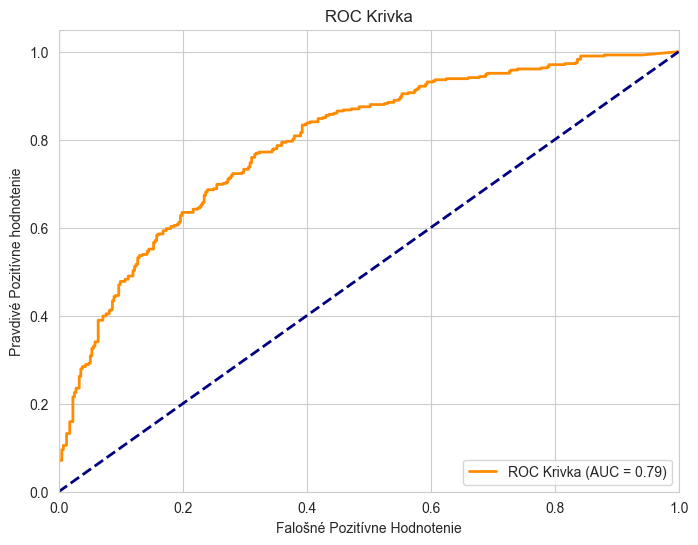

In [295]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = knn_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_knn, tpr_knn, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

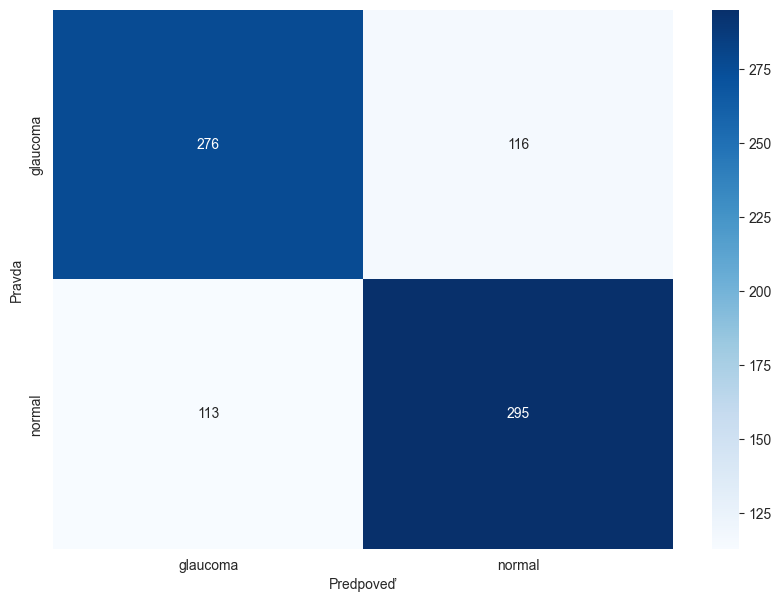

In [296]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm = confusion_matrix(y_test,pred_knn)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=knn_best.classes_, yticklabels=knn_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

AdaBoost

In [297]:
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import AdaBoostClassifier

base_estimators = [rf_best, svm_best, lr_best]

param_grid = {
    'estimator': base_estimators,   # Základný slabý klasifikátor
    'n_estimators': [50, 100]       # Počet klasifikátorov
}

ab = AdaBoostClassifier()
ss = StandardScaler()
scaled_train = ss.fit_transform(X_train)
scaled_test = ss.fit_transform(X_test)
grid_search_ab = GridSearchCV(estimator=ab, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_ab.fit(scaled_train, y_train)
ab_best = grid_search_ab.best_estimator_
pred_ab = ab_best.predict(scaled_test)
score4 = accuracy_score(y_test,pred_ab)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=50; total time=   2.9s
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=50; total time=   2.3s
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=50; total time=   2.2s
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=100; total time=   2.3s
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=100; total time=   2.3s
[CV] END estimator=RandomForestClassifier(max_depth=20, max_features='log2', n_estimators=300), n_estimators=100; total time=   2.2s
[CV] END estimator=SVC(C=300, probability=True), n_estimators=50; total time=  47.0s
[CV] END estimator=SVC(C=300, probability=True), n_estimator

In [217]:
best_params = grid_search_ab.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'estimator': RandomForestClassifier(max_depth=20), 'n_estimators': 50}


In [301]:
print("Accuracy score:", round(score4,4)," on the testing set with AdaBoost.")

Accuracy score: 0.7588  on the testing set with AdaBoost.


In [302]:
print("AdaBoost Classifier Report:")
print(classification_report(y_test, pred_ab, digits=4))

AdaBoost Classifier Report:
              precision    recall  f1-score   support

    glaucoma     0.7277    0.8112    0.7672       392
      normal     0.7961    0.7083    0.7497       408

    accuracy                         0.7588       800
   macro avg     0.7619    0.7598    0.7584       800
weighted avg     0.7626    0.7588    0.7583       800


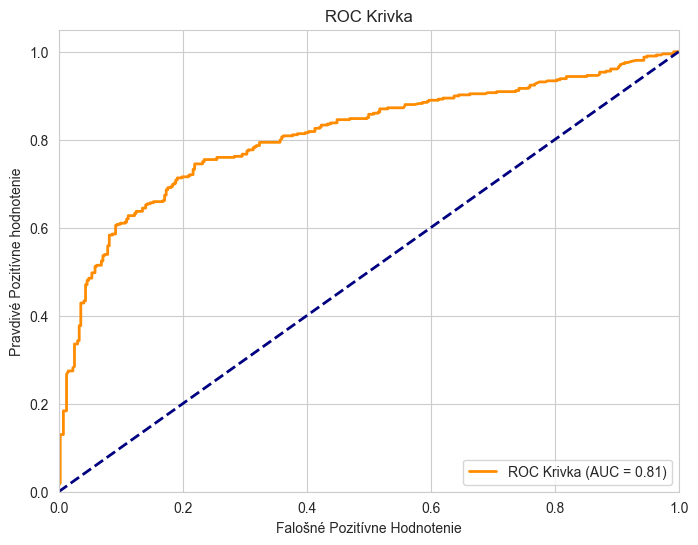

In [298]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_binary = label_encoder.fit_transform(y_test)

test_probs = ab_best.predict_proba(scaled_test)
test_probs = test_probs[:, 1]

fpr_ab, tpr_ab, thresholds = roc_curve(y_test_binary, test_probs)

roc_auc_ab = auc(fpr_ab, tpr_ab)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ab, tpr_ab, color='darkorange', lw=2, label='ROC Krivka (AUC = %0.2f)' % roc_auc_ab)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()

Text(95.72222222222221, 0.5, 'Pravda')

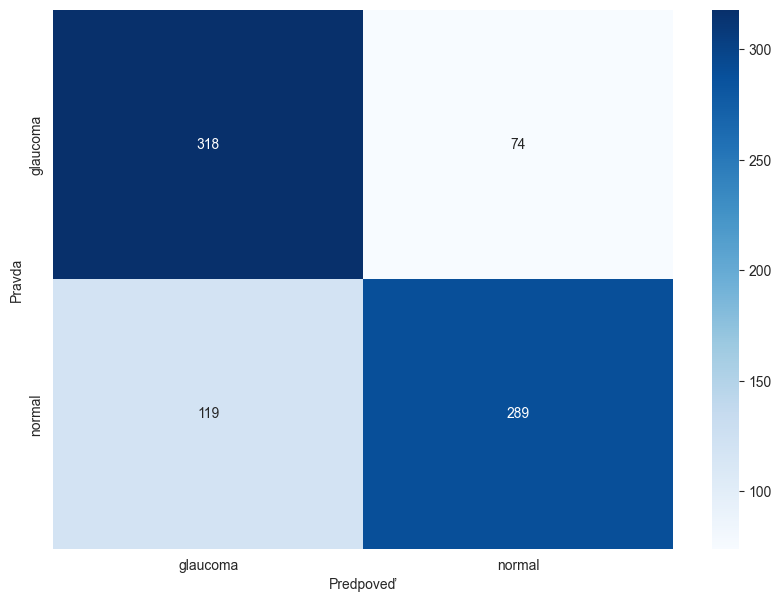

In [299]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

cm = confusion_matrix(y_test,pred_ab)
plt.figure(figsize = (10,7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ab_best.classes_, yticklabels=ab_best.classes_)
plt.xlabel('Predpoveď')
plt.ylabel('Pravda')

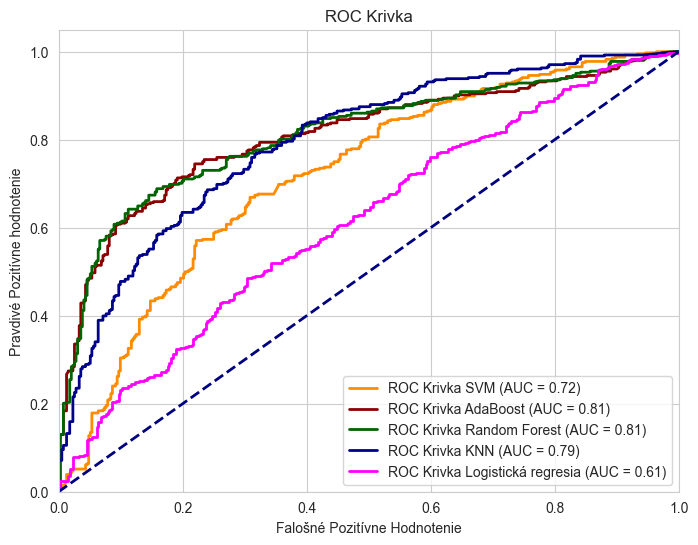

In [300]:
# ROC-AUC krivka pre všetký klasifikátory

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC Krivka SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_ab, tpr_ab, color='darkred', lw=2, label='ROC Krivka AdaBoost (AUC = %0.2f)' % roc_auc_ab)
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label='ROC Krivka Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_knn, tpr_knn, color='darkblue', lw=2, label='ROC Krivka KNN (AUC = %0.2f)' % roc_auc_knn)
plt.plot(fpr_lr, tpr_lr, color='magenta', lw=2, label='ROC Krivka Logistická regresia (AUC = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falošné Pozitívne Hodnotenie')
plt.ylabel('Pravdivé Pozitívne hodnotenie')
plt.title('ROC Krivka')
plt.legend(loc="lower right")
plt.show()